## Introduction and set up

### Theme: Predict Diabetes

Bruno Henrique

In [ ]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/diabetes-prediction-dataset')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('diabetes-prediction-dataset')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

We'll import the fastai tabular library, set a random seed so the notebook is reproducible, and pick a reasonable number of significant figures to display in our tables:

In [2]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Prep the data

We'll read the CSV file just like we did before:

In [3]:
df = pd.read_csv(path/'diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.00,0,0,No Info,27.32,6.20,90,0
99996,Female,2.00,0,0,No Info,17.37,6.50,100,0
99997,Male,66.00,0,0,former,27.83,5.70,155,0
99998,Female,24.00,0,0,never,35.42,4.00,100,0


As we discussed in the last notebook, we can use `RandomSplitter` to separate out the training and validation sets:

In [4]:
splits = RandomSplitter(seed=42)(df)

Now the entire process of getting the data ready for training requires just this one cell!:

In [5]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["gender","smoking_history"],
    cont_names=['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level'],
    y_names="diabetes", y_block = CategoryBlock(),
).dataloaders(path=".")

Here's what each of the parameters means:

- Use `splits` for indices of training and validation sets:

      splits=splits,
    
- Turn strings into categories, fill missing values in numeric columns with the median, normalise all numeric columns:
    
      procs = [Categorify, FillMissing, Normalize],
    
- These are the categorical independent variables:
    
      cat_names=["gender","smoking_history"],
    
- These are the continuous independent variables:
    
      cont_names=['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level'],
    
- This is the dependent variable:
    
      y_names="diabetes",

- The dependent variable is categorical (so build a classification model, not a regression model):

      y_block = CategoryBlock(),

## Train the model

The data and model together make up a `Learner`. To create one, we say what the data is (`dls`), and the size of each hidden layer (`[10,10]`), along with any metrics we want to print along the way:

### Using ``` accuracy ``` metric

In [6]:
learn_acc = tabular_learner(dls, metrics=accuracy, layers=[10,10])

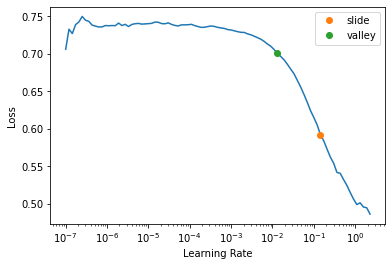

In [7]:
lr_acc_result = learn_acc.lr_find(suggest_funcs=(slide, valley))

In [8]:
learn_acc.fit(3, lr=lr_acc_result[0])

epoch,train_loss,valid_loss,accuracy,time
0,0.140931,0.113574,0.961450,00:12
1,0.139894,0.130573,0.950400,00:12
2,0.151147,0.124446,0.957650,00:12


In [9]:
validation_row = splits[1][180]
row, clas, probs = learn_acc.predict(df.iloc[validation_row])
has_diabetes = row['diabetes'].values[0]
print(f'This person has diabetes? {"No" if has_diabetes == 0 else "Yes"} {has_diabetes}' )
print(f'Model predicted: {probs[0]} of not having diabetes')


This person has diabetes? No 0.0
Model predicted: 0.9461700320243835 of not having diabetes


### Using ``` precision ``` metric

In [10]:
learn_precision = tabular_learner(dls, metrics=Precision(), layers=[10,10])

You'll notice we didn't have to do any messing around to try to find a set of random coefficients that will train correctly -- that's all handled automatically.

One handy feature that fastai can also tell us what learning rate to use:

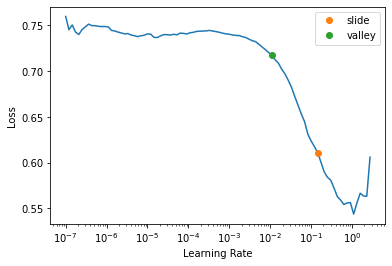

In [11]:
lr_precision_result = learn_precision.lr_find(suggest_funcs=(slide, valley))

The two colored points are both reasonable choices for a learning rate. I'll pick somewhere between the two (0.03) and train for a few epochs:

In [12]:
learn_precision.fit(3, lr=lr_precision_result[0])

epoch,train_loss,valid_loss,precision_score,time
0,0.132660,0.113921,0.892857,00:12
1,0.153834,0.117369,0.944745,00:12
2,0.137699,0.125533,0.972289,00:12


In [13]:
validation_row = splits[1][180]
row, clas, probs = learn_precision.predict(df.iloc[validation_row])
has_diabetes = row['diabetes'].values[0]
print(f'This person has diabetes? {"No" if has_diabetes == 0 else "Yes"} {has_diabetes}' )
print(f'Model predicted: {probs[0]} of not having diabetes')


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This person has diabetes? No 0.0
Model predicted: 0.9736589193344116 of not having diabetes


### Using ``` recall ``` metric

In [14]:
learn_recall = tabular_learner(dls, metrics=Recall(), layers=[10,10])

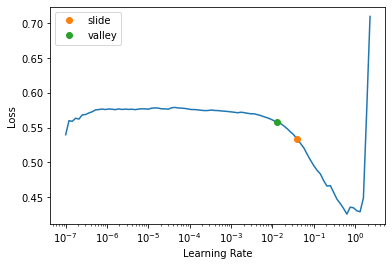

In [15]:
lr_recall_result = learn_recall.lr_find(suggest_funcs=(slide, valley))

In [16]:
learn_recall.fit(2, lr=lr_recall_result[0])

epoch,train_loss,valid_loss,recall_score,time
0,0.114330,0.102162,0.638872,00:12
1,0.120334,0.107639,0.676665,00:12


In [17]:
validation_row = splits[1][180]
row, clas, probs = learn_recall.predict(df.iloc[validation_row])
has_diabetes = row['diabetes'].values[0]
print(f'This person has diabetes? {"No" if has_diabetes == 0 else "Yes"} {has_diabetes}' )
print(f'Model predicted: {probs[0]} of not having diabetes')


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This person has diabetes? No 0.0
Model predicted: 0.8488168120384216 of not having diabetes


# Gradio example

In [ ]:
! pip install -q gradio

In [ ]:
import gradio as gr
import pandas as pd

def predict(Gender, SmokingHistory, Age, Hypertension, HeartDisease, BMI, HbLevel, GlucoseLevel):

    data = [[Gender, SmokingHistory, int(Age), int(Hypertension), int(HeartDisease), float(BMI), float(HbLevel), int(GlucoseLevel)]]

    row_df = pd.DataFrame(data,columns=['gender','smoking_history', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level'])
    
    row, clas, probs = learn_acc.predict(row_df.iloc[0])
    if probs[0] < 0.5:
        return "Tem diabetes"
    else:
        return "Não tem diabetes"

gr.Interface(
    fn=predict,
    title="Predict Diabetes",
    allow_flagging="never",
    inputs=[
        gr.inputs.Radio(["Male", "Female"], label="Gender", default="Male"),
        gr.inputs.Dropdown(
            ["never", "No info", "current" , "former"], label="SmokingHistory", default="never"
        ),
        gr.inputs.Number(default=60, label="Age"),
        gr.inputs.Radio(["1", "0"], label="HyperTension", default="1"),
        gr.inputs.Radio(["1", "0"], label="HeartDisease", default="1"),
        gr.inputs.Number(default=30, label="BMI"),
        gr.inputs.Number(default=5.1, label="HbLevel"),
        gr.inputs.Number(default=90, label="GlucoseLevel")
    ],
    outputs="text").launch()

## Export the model

In [20]:
learn_recall.export('model.pkl')

## Deploy

https://huggingface.co/spaces/BrunoHenrique00/lesson5